In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# pip install scikit-learn
# pip install kagglehub
# pip install ipywidgets

# **Computer Vision and Robot Perceptron**: HW1 - Image Classification using CNNs
In this assignment, you will practice training a CNN from scratch on Tiny-ImageNet, which is a smaller version of ImageNet with 200 classes. Each class contains 500 images in the training set and 50 images in the testing set. The goals of this assignment are as follows:

- Understand the data-driven Image Classification pipeline (train/predict stages).
- Understand the train/val/test splits and the use of validation data for hyperparameter tuning.
- Learn how to finetune the pretrained model on the downstream task.

## Part 1: Training a CNN from scratch on Tiny ImageNet
In this part, you will train a CNN model from scratch, and evaluate your model on the given test set.
To finish this part, you will have to:
1. The data is split into train/val/test, the validation data is randomly selected from the training set, and the testing set is fixed. It is recommeded to do data augmentations, such as slight rotation. Please visit this website for more details: https://pytorch.org/vision/main/transforms.html
2. Create a customized CNN model at your own, any techniques, such as dropout, normalizations, are all welcomed!
3. Plot the training accuracy curve, report the testing accuracy and plot the confusion matrix.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch import Tensor
from typing import Type

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import pdb

import kagglehub

### Step 1: Download the Tiny ImageNet dataset from Kaggle
Please DO NOT modify this cell.

In [ ]:
# Download tiny imagenet
base_dir = kagglehub.dataset_download("huchanwei123/cvrp-tinyimagenet")
print("Path to dataset files:", base_dir)
train_dir = os.path.join(base_dir, 'tiny-imagenet/train')
test_dir = os.path.join(base_dir, 'tiny-imagenet/test')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Path to dataset files: C:\Users\partho.ghose\.cache\kagglehub\datasets\huchanwei123\cvrp-tinyimagenet\versions\1


### Step 2: Create the data loader, and split it to train/val
1. The original folder structure is: \
   ├── train \
│   ├── labels (such as n01443537) \
│   │   ├── images \
│   │   │   ├── n01443537_0.JPEG \
│   │   │   ├── n01443537_1.JPEG \
│   │   │   ├── ... \
   It is highly recommended to use ```dataset.ImageFolder``` to load the data!
2. To check how to transform your data, check here: https://pytorch.org/vision/main/transforms.html
3. Later when you train the model, you might need to tune hyperparameters. For example, you may not want the fixed learning rate.


In [ ]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Parameters
img_size = 64

# Hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 20
num_classes = 200

# Data transformations with augmentation for training set
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(degrees=15),  # Slight rotation augmentation
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transformations (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset loading with transformations
dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)

# Split train and validation datasets
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply the transformation for validation dataset (no augmentation)
val_dataset.dataset.transform = val_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Example of iterating through the training loader
for images, labels in train_loader:
    print(f"Batch image size: {images.size()}")
    print(f"Batch label size: {labels.size()}")
    break


Training set size: 80000
Validation set size: 20000
Batch image size: torch.Size([32, 3, 64, 64])
Batch label size: torch.Size([32])


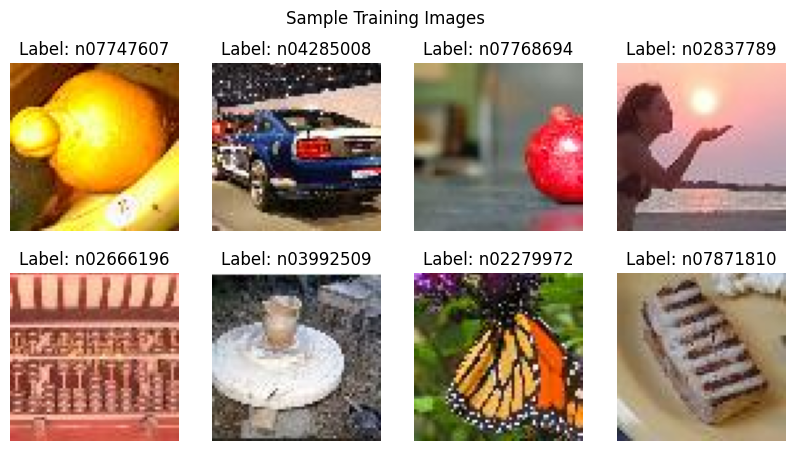

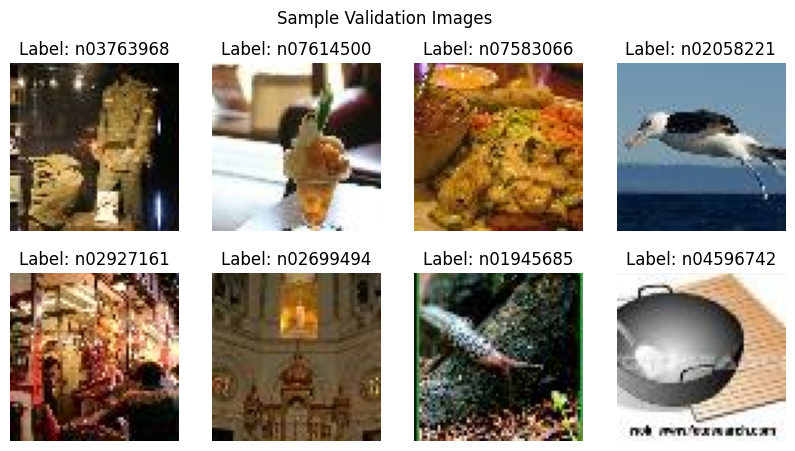

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Class names from the dataset
class_names = dataset.classes

# Function to display images with labels
def show_images(images, labels, title=None):
    plt.figure(figsize=(10, 5))
    images = images.numpy().transpose((0, 2, 3, 1))  # Change to HWC format for display
    images = np.clip(images * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)  # Un-normalize

    for i in range(min(8, len(images))):  # Show up to 8 images
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[labels[i].item()]}")
        plt.axis('off')

    if title:
        plt.suptitle(title)
    plt.show()


# Display some examples from the training set
train_iter = iter(train_loader)
images, labels = next(train_iter)
show_images(images, labels, title="Sample Training Images")

# Display some examples from the validation set
val_iter = iter(val_loader)
images, labels = next(val_iter)
show_images(images, labels, title="Sample Validation Images")

# # Display some examples from the test set
# test_iter = iter(test_loader)
# images, labels = next(test_iter)
# show_images(images, labels, title="Sample Test Images")


### Step 3: Create your own CNN!
More details can be found here: https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch

In [12]:
### Define the custom CNN model
class yourCNN(nn.Module):
    def __init__(self, num_classes=200):
        super(yourCNN, self).__init__()
        # Conv layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fourth conv block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



### Step 4: We are now ready to train the CNN model!
1. Define your model with your CNN class!
2. Define the loss function (```CrossEntropyLoss()```?) and the optimizer. More details can be found here: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [13]:
### Define the model
model = yourCNN(num_classes=num_classes).to(device)
#print(model)


### Define the Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer =optim.Adam(model.parameters(), lr=learning_rate)

### Step 5: Implement your training procedure!
#### For training:
1. Iterate through each batch in the train dataloader
2. Reset the optimizer
3. Calculate the loss
4. Do backpropagation!
5. Keep track of the loss and accuracy when finishing this epoch

#### For evaluating:
Similar to the training process, but DON'T train the model! Only prediction!

**NOTE**: It is to modify the in/out arguments of ```train_model``` function

In [14]:
import torch

### Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device='cuda'):
    # Move the model to the correct device
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Iterate through each batch in the training data loader
        for inputs, labels in train_loader:
            # Move inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backpropagation
            loss.backward()

            # Update the model's parameters
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for this epoch
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # No gradients needed during validation
            for inputs, labels in val_loader:
                # Move inputs and labels to the same device as the model
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate the loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy for this epoch
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies, model


### Step 6: Start training the model!
Actually nothing to do in this cell...

Epoch [1/20], Train Loss: 5.1348, Train Accuracy: 1.48%, Val Loss: 4.9262, Val Accuracy: 2.83%
Epoch [2/20], Train Loss: 4.9898, Train Accuracy: 2.23%, Val Loss: 4.6386, Val Accuracy: 5.17%
Epoch [3/20], Train Loss: 4.6835, Train Accuracy: 4.81%, Val Loss: 4.2082, Val Accuracy: 10.38%
Epoch [4/20], Train Loss: 4.2897, Train Accuracy: 9.48%, Val Loss: 3.8697, Val Accuracy: 15.96%
Epoch [5/20], Train Loss: 3.9508, Train Accuracy: 14.22%, Val Loss: 3.5338, Val Accuracy: 20.74%
Epoch [6/20], Train Loss: 3.6914, Train Accuracy: 18.24%, Val Loss: 3.3977, Val Accuracy: 23.00%
Epoch [7/20], Train Loss: 3.5024, Train Accuracy: 21.34%, Val Loss: 3.2673, Val Accuracy: 26.05%
Epoch [8/20], Train Loss: 3.3297, Train Accuracy: 24.04%, Val Loss: 3.1725, Val Accuracy: 27.95%
Epoch [9/20], Train Loss: 3.1711, Train Accuracy: 26.82%, Val Loss: 3.0433, Val Accuracy: 30.20%
Epoch [10/20], Train Loss: 3.0425, Train Accuracy: 29.17%, Val Loss: 2.9712, Val Accuracy: 31.36%
Epoch [11/20], Train Loss: 2.9208, 

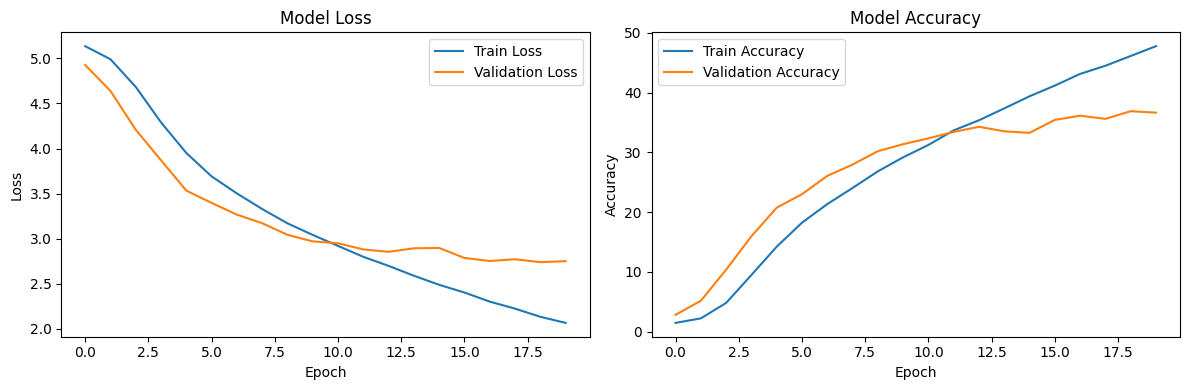

In [ ]:
### Train the model
train_losses, val_losses, train_accuracies, val_accuracies, model = train_model(model, train_loader, val_loader, criterion, optimizer)

### We will save the model, in part 2 we gonna use it!

# Define the full path where the model weights will be saved
model_path = os.path.join('/content/drive/MyDrive/CVP/CVPR1', 'CNN_weights_full_dataset.pth')

# Save the model weights
torch.save(model.state_dict(), model_path)

### Plot results. This is a naive plot, you are encouraged to improve it!
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Compute and print the average training and validation accuracy
avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

print(f"Average Training Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")


Average Training Accuracy: 27.57%
Average Validation Accuracy: 27.06%


### Step 7: Evaluate your model on testing set and plot the confusion matrix
In this part, you will learn to evaluate a trained model on testing set, and plot the confusion matrix.
Ideally, a great classification model would have non-zero values only along the diagonal, with zeros in all off-diagonal elements.

**HINTS**
1. Remember to perform the same transforms to your testing set as the validation set.
2. In ```get_predictions```, it is basically the same as you do evaluation.

In [ ]:

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Apply normalization
])

# Apply transformation to test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Define test loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Test dataset size: {len(test_dataset)}")


Test dataset size: 10000


In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix

### If you don't want to train the model again, you can restore it
model.load_state_dict(torch.load('/content/drive/MyDrive/CVPR/CNN_weights_full_dataset.pth'))
model.eval()  # Set the model to evaluation mode

# Function to get predictions and true labels
def get_predictions(model, dataloader):
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels)

### Get predictions and true labels
predictions, true_labels = get_predictions(model, test_loader)

################# Compute confusion matrix ##################
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

### Calculate accuracy
accuracy = (predictions == true_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

### Plot Confusion Matrix (Optional for Visualization)
import matplotlib.pyplot as plt
import seaborn as sns

# Access the classes from the original dataset (train_dataset)
plt.figure(figsize=(64, 62))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Confusion Matrix:
[[29  0  2 ...  0  0  0]
 [ 0 25  1 ...  0  0  0]
 [ 0  0 18 ...  1  0  4]
 ...
 [ 0  0  0 ...  7  6  0]
 [ 0  0  0 ...  2 24  0]
 [ 0  0  0 ...  0  0 13]]
Test Accuracy: 0.3584


### Questions
1. Did you observe overfitting? If yes, how did you address it?


Ans: Yes, I obseved a little bit overfitting during trtaining but not that much.
 I applied data augmentation to the training dataset, including slight rotations and flipping. Additionally, I incorporated batch normalization and dropout layers to help regularize the model and improve generalization.


2. The original dataset is well-balanced, that is, each class has the same number of training examples. However, this rarely happens in the real situation because some classes may dominate the training set. For example, in autonomous driving application, most training data are vehicles moving forward, while moving backwards take a small amount. This is called longtailed dataset. You will have to train the same CNN model on tiny-imagenet dataset with longtailed distribution.
   
   ```base_dir = kagglehub.dataset_download("huchanwei123/cvrp-tinyimagenet-lt")``` \
   ```train_dir = os.path.join(base_dir, 'tiny-imagenet-lt/train')``` \
   ```test_dir = os.path.join(base_dir, 'tiny-imagenet-lt/test')```

   Please plot out the trainig data distribuion (x-axis: class ID, y-axis: number of images), and analyze the performance compared to original dataset.
3. With your results trained on longtailed tiny-imagenet, you might observe the lower testing accuracy. Please try to improve the algorithm by performing a more **aggresive data augmentation** or **frequent re-sampling on tail classes**. (Note: Just try your best!)

In [7]:
base_dir = kagglehub.dataset_download("huchanwei123/cvrp-tinyimagenet-lt")
train_dir = os.path.join(base_dir, 'tiny-imagenet-lt/train')
test_dir = os.path.join(base_dir, 'tiny-imagenet-lt/test')
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 105M/105M [00:01<00:00, 63.8MB/s] 

Extracting files...


In [8]:
# Count images in each folder
def count_images_in_folder(folder):
    return sum([len(files) for _, _, files in os.walk(folder)])

train_image_count = count_images_in_folder(train_dir)
test_image_count = count_images_in_folder(test_dir)

print(f"Number of images in training folder: {train_image_count}")
print(f"Number of images in testing folder: {test_image_count}")

Number of images in training folder: 43355
Number of images in testing folder: 10000


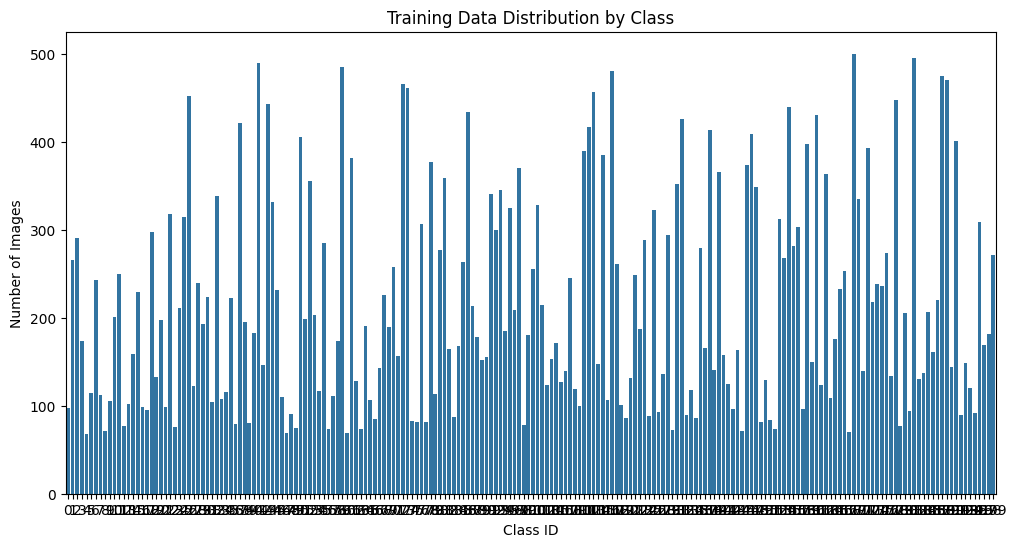

In [9]:
# Load dataset
from collections import Counter

train_dataset = datasets.ImageFolder(root=train_dir)

# Count the number of images per class
class_counts = Counter([label for _, label in train_dataset.imgs])

# Plot the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.title("Training Data Distribution by Class")
plt.show()

In [6]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Parameters
img_size = 64

# Hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 20
num_classes = 200

# Data transformations with augmentation for training set
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(degrees=15),  # Slight rotation augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transformations (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset loading with transformations
dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)

# Split train and validation datasets
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply the transformation for validation dataset (no augmentation)
val_dataset.dataset.transform = val_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Example of iterating through the training loader
for images, labels in train_loader:
    print(f"Batch image size: {images.size()}")
    print(f"Batch label size: {labels.size()}")
    break


Training set size: 34684
Validation set size: 8671


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch image size: torch.Size([32, 3, 64, 64])
Batch label size: torch.Size([32])


**Model**

In [9]:
### Define the custom CNN model
class yourCNN(nn.Module):
    def __init__(self, num_classes=200):
        super(yourCNN, self).__init__()
        # Conv layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fourth conv block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [10]:
### Define the model
model = yourCNN(num_classes=num_classes).to(device)
print(model)


### Define the Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer =optim.Adam(model.parameters(), lr=learning_rate)

yourCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, a

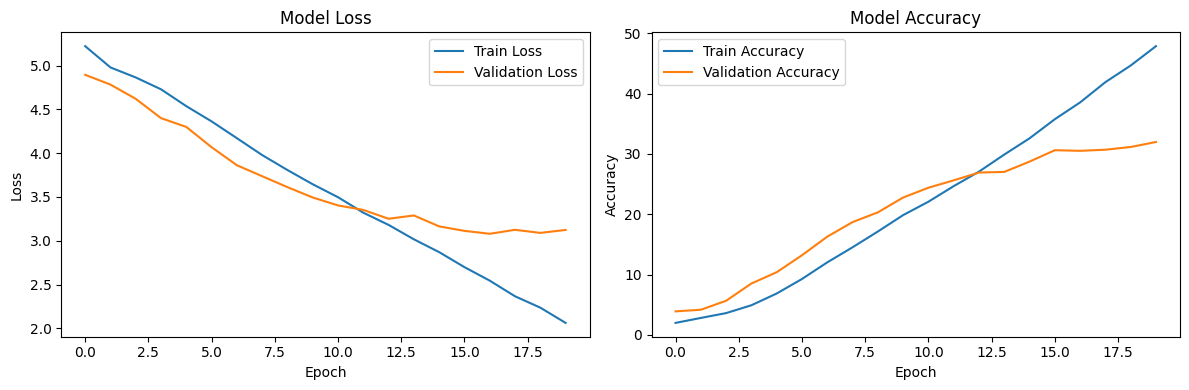

In [ ]:
### Train the model
train_losses, val_losses, train_accuracies, val_accuracies, model = train_model(model, train_loader, val_loader, criterion, optimizer)

### We will save the model, in part 2 we gonna use it!

# Define the full path where the model weights will be saved
model_path = os.path.join('/content/drive/MyDrive/CVP/CVPR1', 'CNN_weights_lt_dataset.pth')

# Save the model weights
torch.save(model.state_dict(), model_path)

### Plot results. This is a naive plot, you are encouraged to improve it!
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Compute and print the average training and validation accuracy
avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

print(f"Average Training Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")


Average Training Accuracy: 21.90%
Average Validation Accuracy: 20.57%


In [17]:

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Apply normalization
])

# Apply transformation to test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Define test loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Test dataset size: {len(test_dataset)}")


Test dataset size: 10000


Confusion Matrix:
[[12  0  0 ...  0  0  0]
 [ 0 26  2 ...  0  1  0]
 [ 0  1 13 ...  0  0  2]
 ...
 [ 0  0  0 ...  4  6  0]
 [ 2  0  1 ...  9 16  0]
 [ 0  1  2 ...  0  0 16]]
Test Accuracy: 0.2561


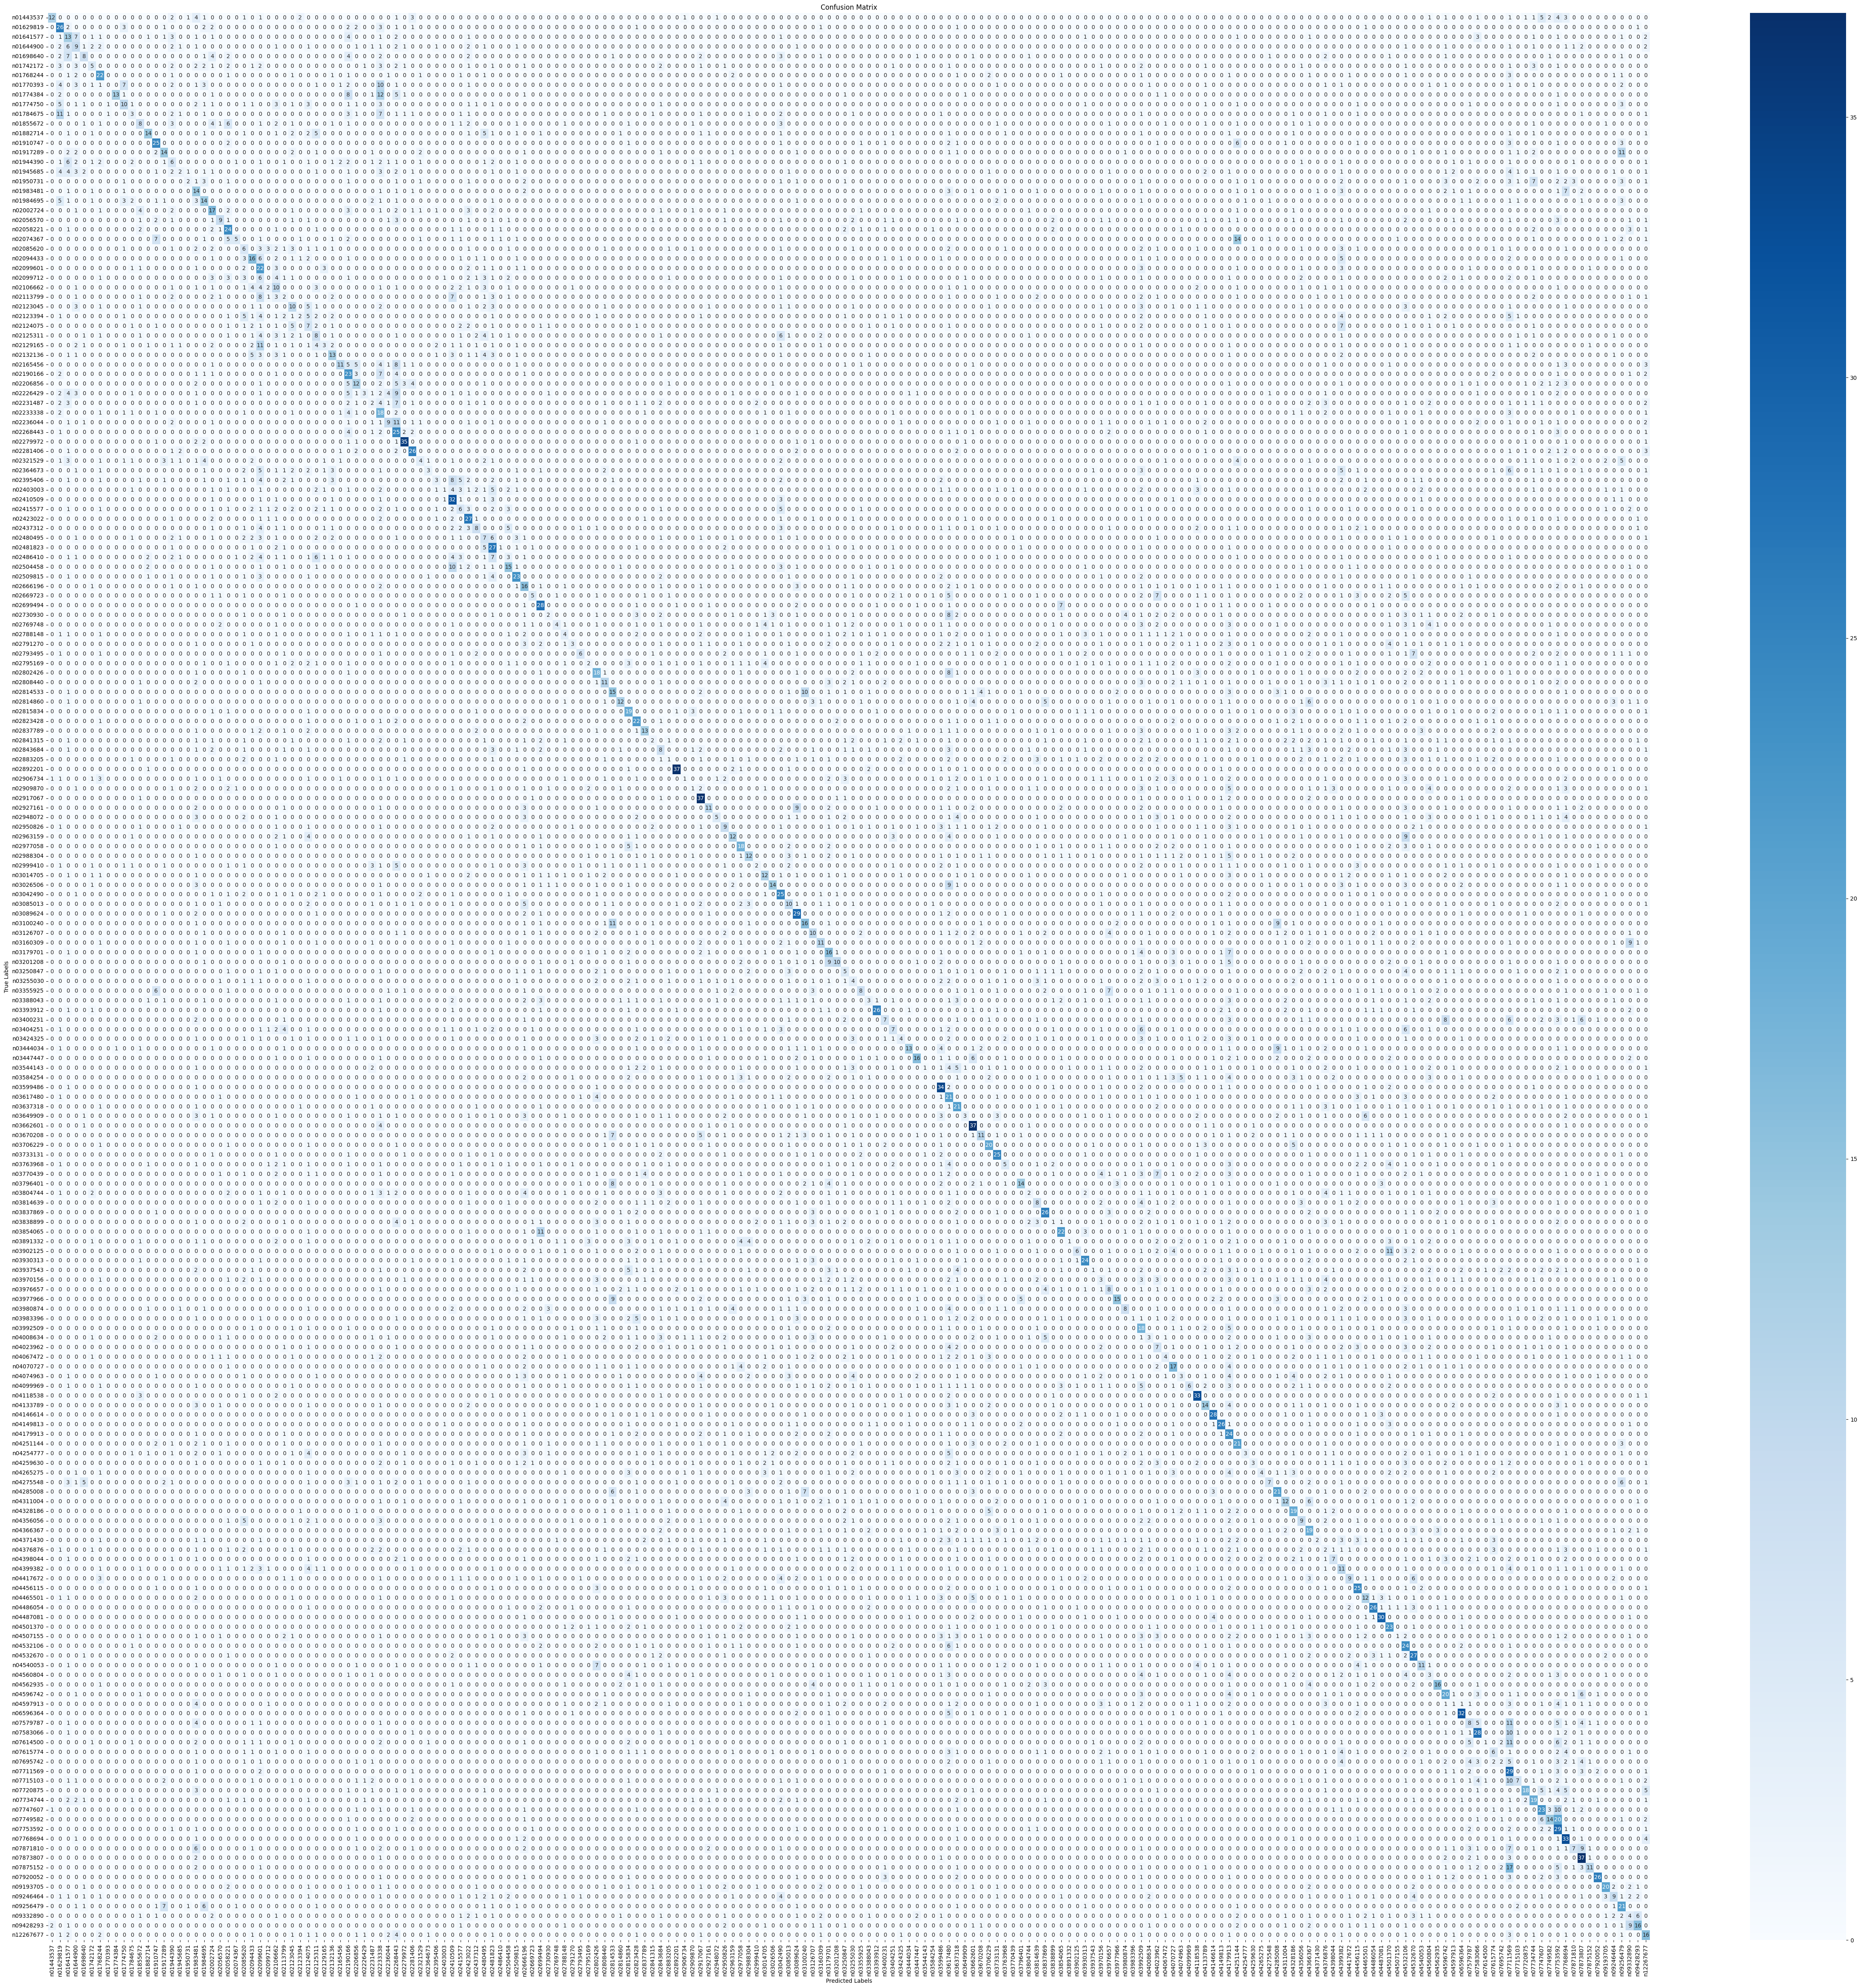

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix

### If you don't want to train the model again, you can restore it
model.load_state_dict(torch.load('/content/drive/MyDrive/CVPR/CNN_weights_lt_dataset.pth'))
model.eval()  # Set the model to evaluation mode

# Function to get predictions and true labels
def get_predictions(model, dataloader):
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the class index with max probability

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels)

### Get predictions and true labels
predictions, true_labels = get_predictions(model, test_loader)

################# Compute confusion matrix ##################
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

### Calculate accuracy
accuracy = (predictions == true_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

### Plot Confusion Matrix (Optional for Visualization)
import matplotlib.pyplot as plt
import seaborn as sns

# Access the classes from the original dataset (train_dataset)
plt.figure(figsize=(64, 62))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


**Using Upsampling**

In [10]:
import os
import torch
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, Subset
from torchvision import datasets, transforms
from collections import Counter
import numpy as np

# Parameters
img_size = 64

# Hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 20
num_classes = 200

# Data transformations with augmentation for training set
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(degrees=15),  # Slight rotation augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transformations (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset loading with transformations
dataset = datasets.ImageFolder(root=train_dir)

# Split train and validation datasets
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply transformations manually (because random_split does not keep transform info)
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

# Compute class frequencies in the training dataset
labels = [train_dataset.dataset.targets[idx] for idx in train_dataset.indices]
class_counts = Counter(labels)

# Find max class count for upsampling
max_count = max(class_counts.values())

# Upsample minority classes by duplicating them
upsampled_indices = []
for cls, count in class_counts.items():
    class_indices = [i for i, label in zip(train_dataset.indices, labels) if label == cls]
    upsampled_indices.extend(class_indices * (max_count // count))  # Repeat to balance
    upsampled_indices.extend(np.random.choice(class_indices, max_count % count, replace=True))  # Random extra

# Create new train dataset with upsampled indices
train_dataset = Subset(train_dataset.dataset, upsampled_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Original Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Example of iterating through the training loader
for images, labels in train_loader:
    print(f"Batch image size: {images.size()}")
    print(f"Batch label size: {labels.size()}")
    break


Original Training set size: 79600
Validation set size: 8671


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch image size: torch.Size([32, 3, 64, 64])
Batch label size: torch.Size([32])


<ipython-input-11-57a8b1e72511>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


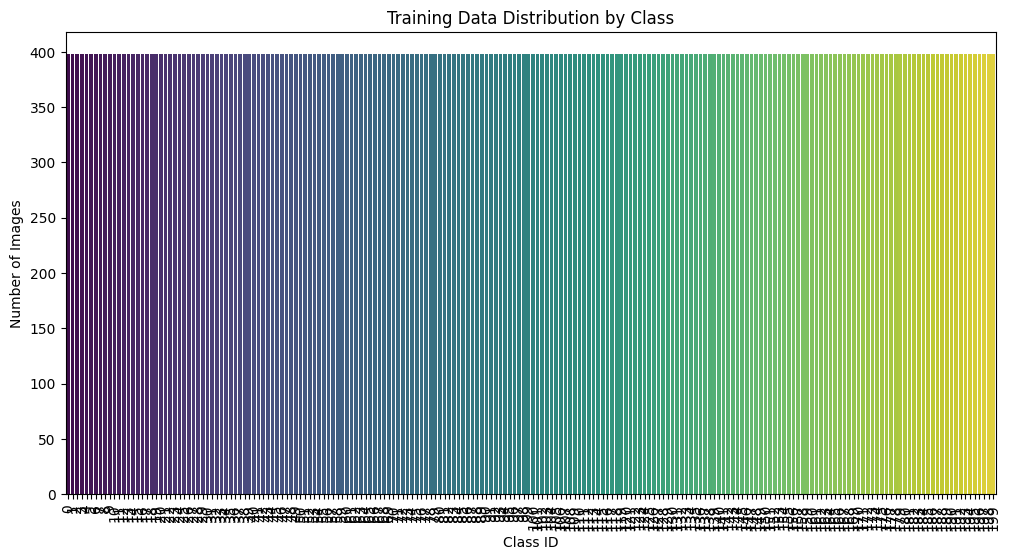

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Extract class labels from train_dataset
train_labels = [label for _, label in train_dataset]

# Count number of images per class
class_counts = Counter(train_labels)

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.title("Training Data Distribution by Class")
plt.xticks(rotation=90)  # Rotate labels if there are many classes
plt.show()


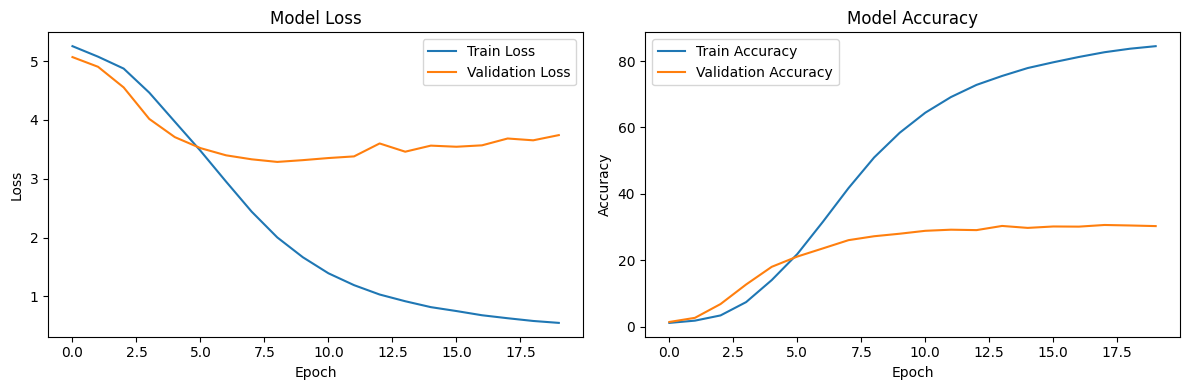

In [ ]:
### Train the model
train_losses, val_losses, train_accuracies, val_accuracies, model = train_model(model, train_loader, val_loader, criterion, optimizer)

### We will save the model, in part 2 we gonna use it!

# Define the full path where the model weights will be saved
model_path = os.path.join('/content/drive/MyDrive/CVPR', 'CNN_weights_lt_US_dataset.pth')

# Save the model weights
#torch.save(model.state_dict(), model_path)

### Plot results. This is a naive plot, you are encouraged to improve it!
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Compute and print the average training and validation accuracy
avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

print(f"Average Training Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")


Average Training Accuracy: 50.20%
Average Validation Accuracy: 23.35%


In [19]:

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Apply normalization
])

# Apply transformation to test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Define test loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Test dataset size: {len(test_dataset)}")


Test dataset size: 10000


Confusion Matrix:
[[21  0  1 ...  0  0  0]
 [ 0 24  2 ...  0  0  2]
 [ 0  1 13 ...  0  0  2]
 ...
 [ 0  0  0 ...  3  7  0]
 [ 1  0  0 ...  0 18  0]
 [ 0  1  0 ...  0  0 16]]
Test Accuracy: 0.2492


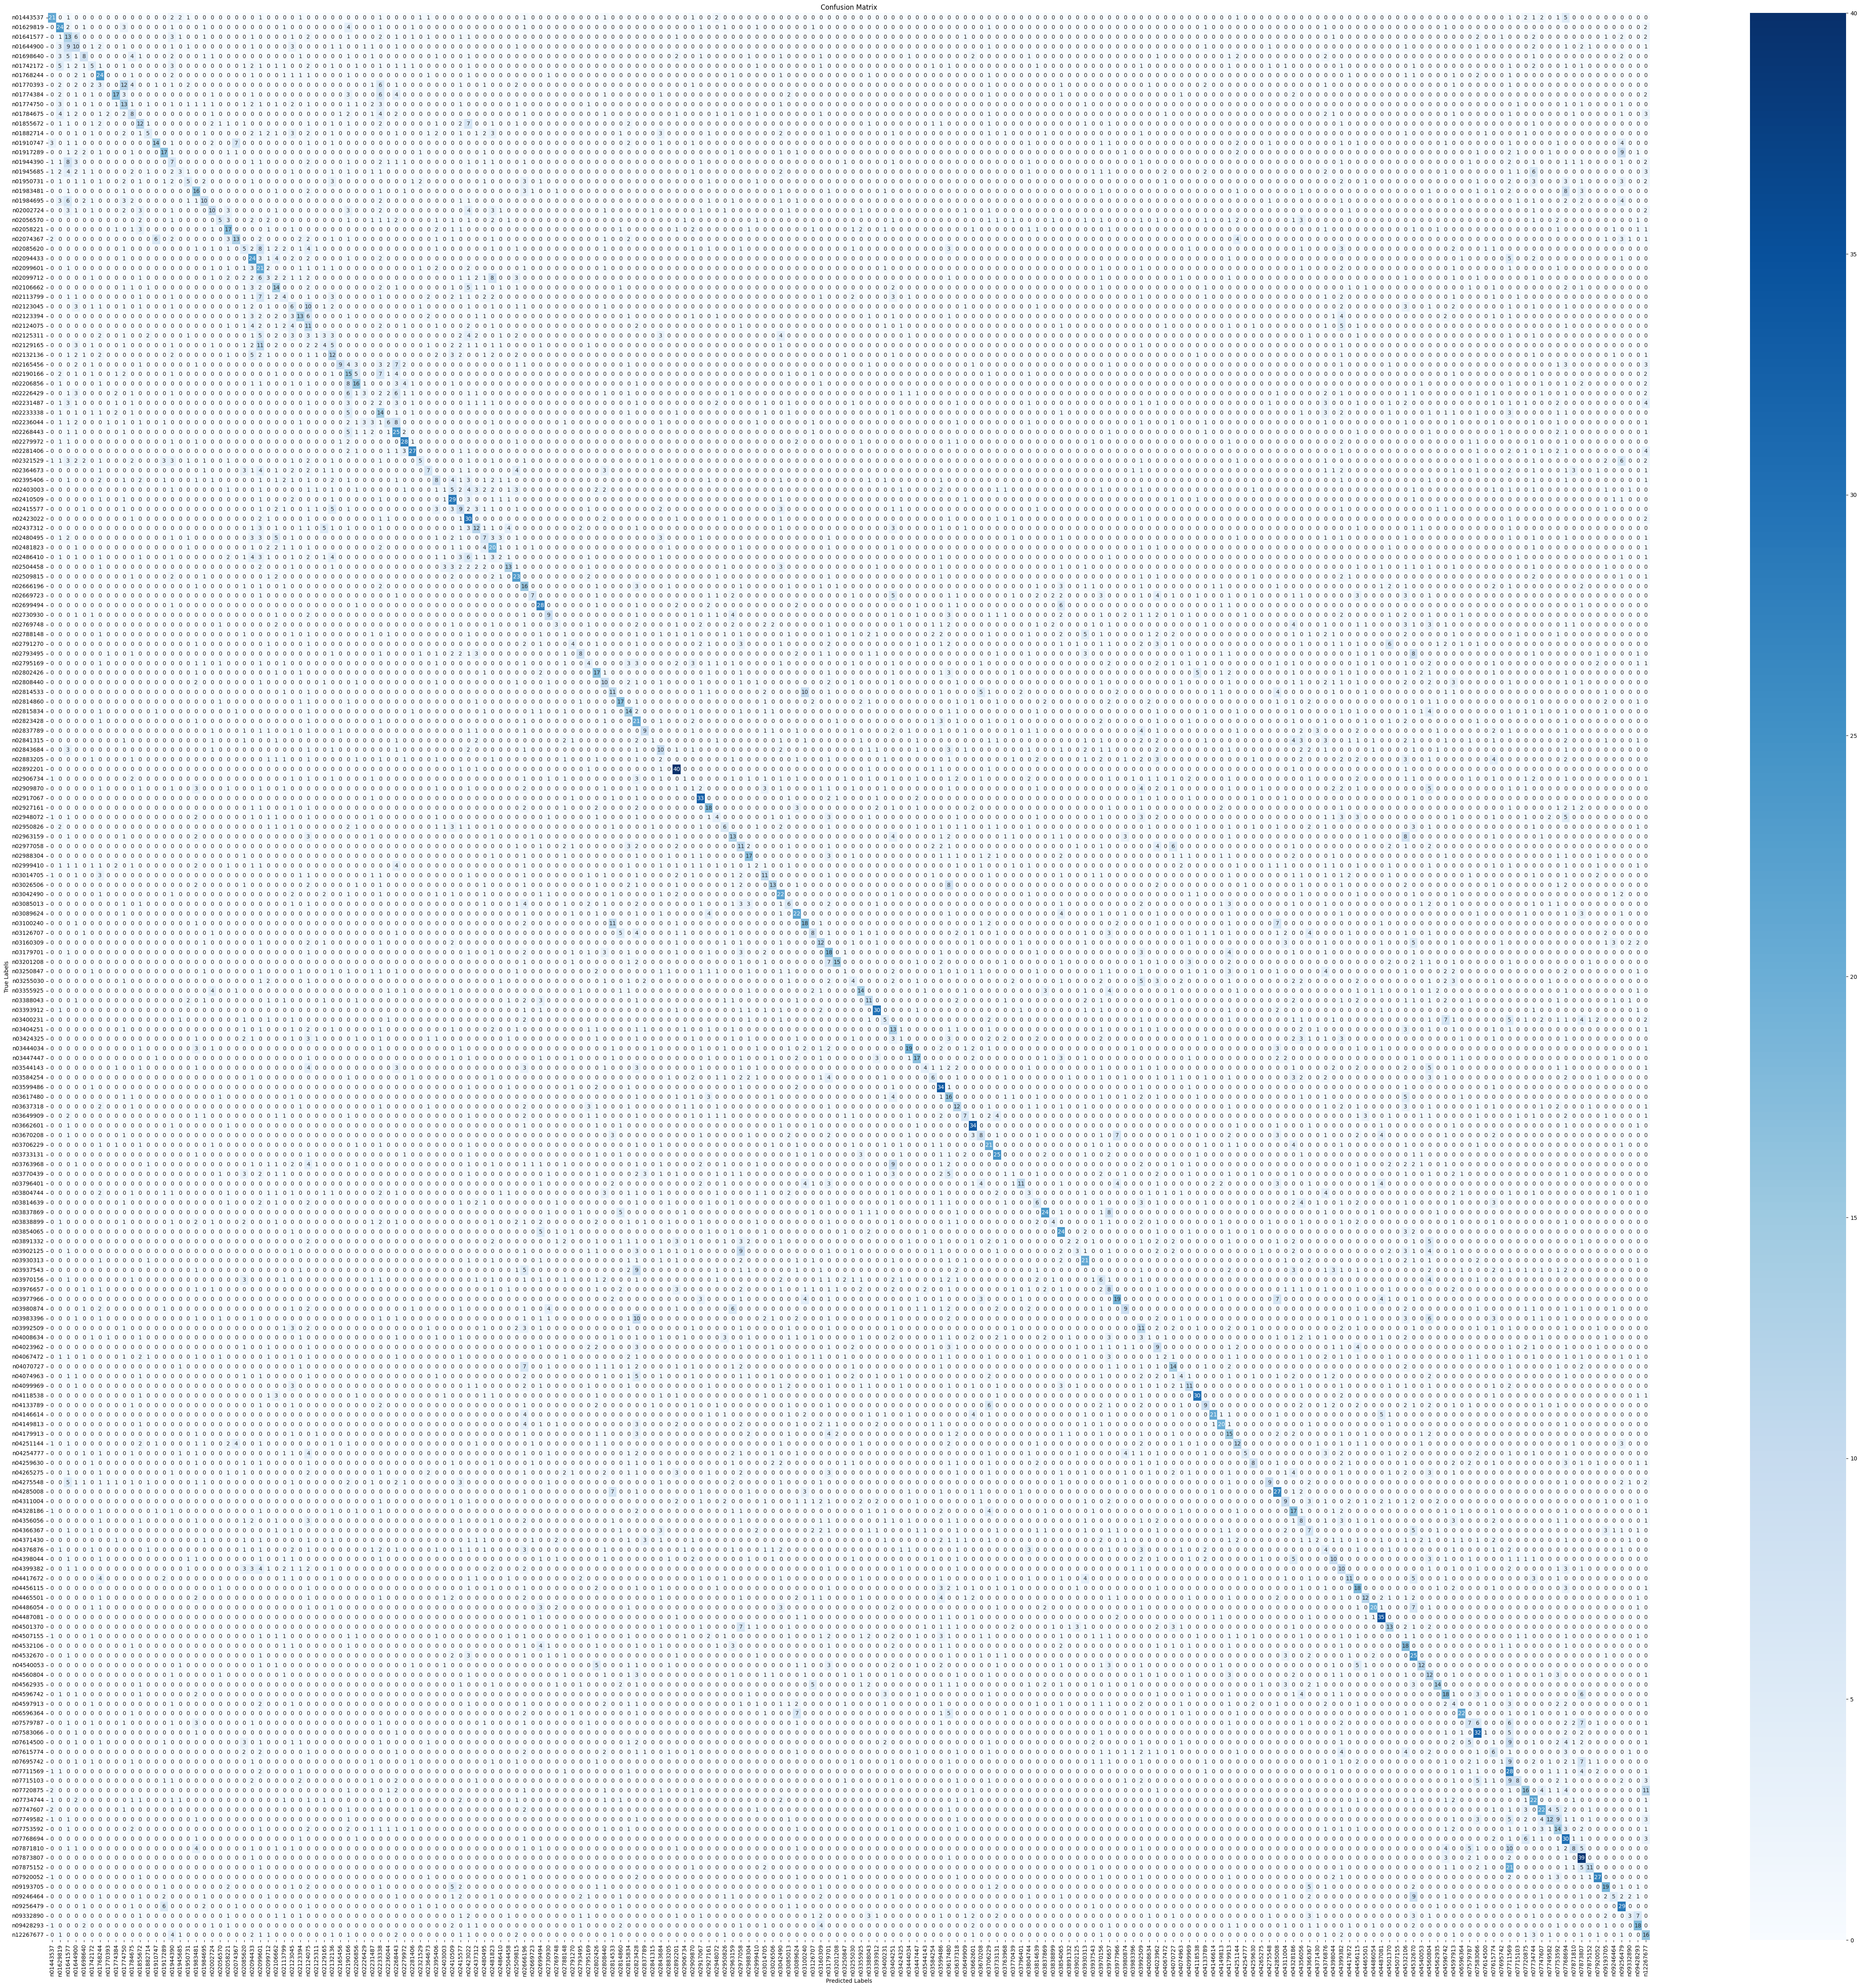

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix

### If you don't want to train the model again, you can restore it
model.load_state_dict(torch.load('/content/drive/MyDrive/CVPR/CNN_weights_lt_US_dataset.pth'))
model.eval()  # Set the model to evaluation mode

# Function to get predictions and true labels
def get_predictions(model, dataloader):
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the class index with max probability

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels)

### Get predictions and true labels
predictions, true_labels = get_predictions(model, test_loader)

################# Compute confusion matrix ##################
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

### Calculate accuracy
accuracy = (predictions == true_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

### Plot Confusion Matrix (Optional for Visualization)
import matplotlib.pyplot as plt
import seaborn as sns

# Access the classes from the original dataset (train_dataset)
plt.figure(figsize=(64, 62))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Training on the long-tailed dataset without applying any data augmentation techniques indeed dropped the testing accuracy. On the balanced data the tesing accuracy was 35.84 percent and on the long-tailed dataset the accuracy dropped to around 25.61 percent.

After applying more aggressive data transformations—such as random cropping, rotations, color jitter, and horizontal flips—along with upsampling all minority classes, the model was retrained on the dataset. However, the test accuracy dropped a little bit further to 24.92%, likely due to overly strong augmentations. The poor training performance suggests that the model is struggling to learn meaningful representations, as evident from the train and validation accuracy curves. Further experimentation with hyperparameters and data augmentation strategies is necessary, but due to limited computing resources, this was not feasible.